In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
from PIL import Image
import requests
from transformers import AutoProcessor, SiglipVisionModel, SiglipImageProcessor
import torch
import inspect
import matplotlib.pyplot as plt


model = SiglipVisionModel.from_pretrained("google/siglip2-base-patch16-224")
processor = SiglipImageProcessor.from_pretrained("google/siglip2-base-patch16-224")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/253 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

In [ ]:
from transformers import SiglipVisionConfig

config = SiglipVisionConfig.from_pretrained("google/siglip2-base-patch16-224")
print(config)

SiglipVisionConfig {
  "attention_dropout": 0.0,
  "hidden_act": "gelu_pytorch_tanh",
  "hidden_size": 768,
  "image_size": 224,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-06,
  "model_type": "siglip_vision_model",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "transformers_version": "4.50.3"
}



In [ ]:
import inspect

methods = [name for name, func in inspect.getmembers(processor, predicate=inspect.ismethod)]

print(inspect.signature(processor.__call__))

(images, **kwargs) -> transformers.image_processing_base.BatchFeature


In [ ]:
print(728/14)

52.0


In [ ]:
url = "/content/drive/MyDrive/c_data/4.jpg"
image = Image.open(url)
width, height = image.size

# print(f"The image resolution is: {width}x{height}")
image.show()
# plt.show(
# print(inspect.signature(model.forward))
# methods = inspect.getmembers(model, predicate=inspect.ismethod)
# for name, method in methods:
#     print(name)
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs, output_attentions = True)
print(len(outputs['attentions']))

SiglipModel is using SiglipSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


12


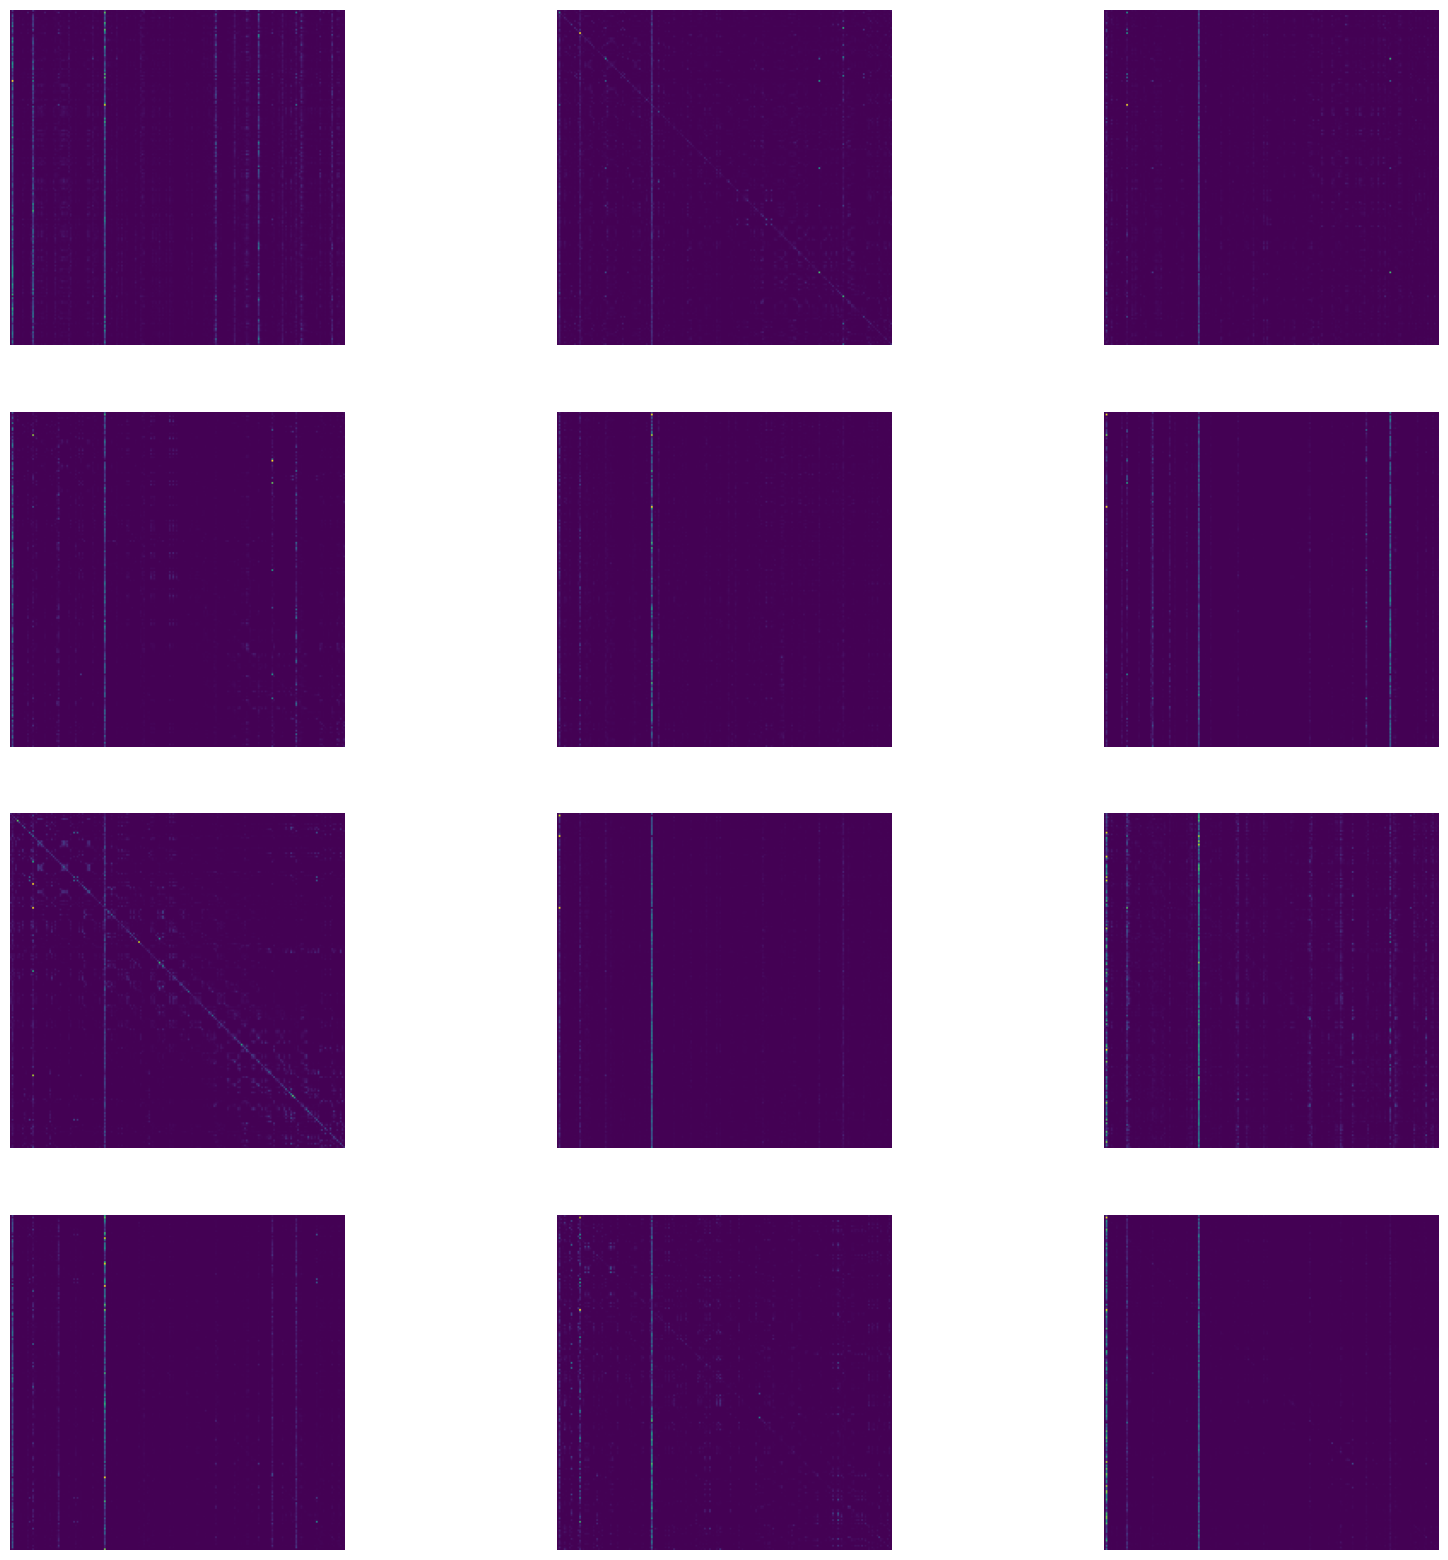

In [ ]:

ig, axs = plt.subplots(4, 3, figsize=(20, 20))
attentions = outputs.attentions
# print(f"Attention min and max - {attentions.min()} and {attentions.max()}")
for i, ax in enumerate(axs.flatten()):

    ax.imshow(attentions[-1][0, i, :, :].detach().cpu().numpy())
    ax.axis('off')

In [ ]:
def attention_rollout(attentions):
    # Initialize rollout with identity matrix
    rollout = torch.eye(attentions[0].size(-1)).to(attentions[0].device)


    # Multiply attention maps layer by layer
    for attention in attentions:
        attention_heads_fused = attention.mean(dim=1) # Average attention across heads
        attention_heads_fused += torch.eye(attention_heads_fused.size(-1)).to(attention_heads_fused.device) # A + I
        attention_heads_fused /= attention_heads_fused.sum(dim=-1, keepdim=True) # Normalizing A
        rollout = torch.matmul(rollout, attention_heads_fused) # Multiplication
    return rollout

def visualize_rollout(rollout):
    rollout_attn_map = rollout[0,:,:].detach().cpu().numpy()
    rollout_attn_map = (rollout_attn_map - rollout_attn_map.min()) / (rollout_attn_map.max() - rollout_attn_map.min())
    rollout_attn_map *= 255
    rollout_attn_map = rollout_attn_map.astype(np.uint8)
    print(np.argmax(rollout_attn_map[0]))
    plt.figure(figsize=(6, 6))
    plt.imshow(rollout_attn_map, cmap='inferno')
    plt.title("Resized & Blurred Attention Map")
    plt.axis('off')
    plt.show()

In [ ]:
print(len(attentions))

12


torch.Size([1, 196, 196])
torch.Size([196])
torch.Size([196])
55


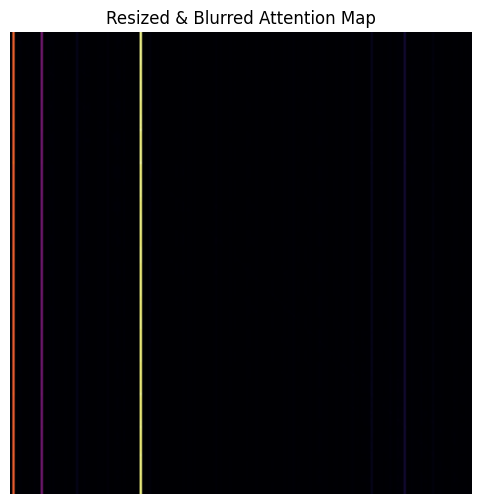

In [ ]:
import numpy as np
from math import gcd

rollout = attention_rollout(attentions)
print(rollout.shape)
cls_attention_c = rollout[0, :, 0]
cls_attention_r = rollout[0, :, 19]
print(cls_attention_r.shape)  # Get attention values from [CLS] token to all patches
print(cls_attention_c.shape)  # Get attention values from [CLS] token to all patches
# Helper to find a good 2D reshape size
# def find_reshape_dims(n):
#     for i in range(int(np.sqrt(n)), 0, -1):
#         if n % i == 0:
#             return (i, n // i)
#     return (n, 1)
cls_attention_c = 1 - cls_attention_c.reshape(int(np.sqrt(196)), int(np.sqrt(196)))

cls_attention_r = 1 - cls_attention_r.reshape(int(np.sqrt(196)), int(np.sqrt(196)))

# cls_attention = rollout[0, 1:, 0]  # Get attention values from [CLS] token to all patches
# cls_attention = 1 - cls_attention.reshape(int(np.sqrt(num_of_patches)), int(np.sqrt(num_of_patches)))
visualize_rollout(rollout)


In [ ]:
import numpy as np
from PIL import Image, ImageFilter
# Normalize the attention map for better visualization
cls_attention_c = (cls_attention_c - cls_attention_c.min()) / (cls_attention_c.max() - cls_attention_c.min())
cls_attention_r = (cls_attention_r - cls_attention_r.min()) / (cls_attention_r.max() - cls_attention_r.min())
# Convert tensor to NumPy
cls_attention_np_c = cls_attention_c.detach().numpy()   # If on GPU, move to CPU first
cls_attention_np_r = cls_attention_r.detach().numpy()
# Convert to image
cls_attention_resized_c = Image.fromarray((cls_attention_np_c * 255).astype(np.uint8)).resize((width, height), resample=Image.BICUBIC)
cls_attention_resized_r = Image.fromarray((cls_attention_np_r * 255).astype(np.uint8)).resize((width, height), resample=Image.BICUBIC)
# cls_attention_resized = cls_attention_resized.filter(ImageFilter.GaussianBlur(radius=2))


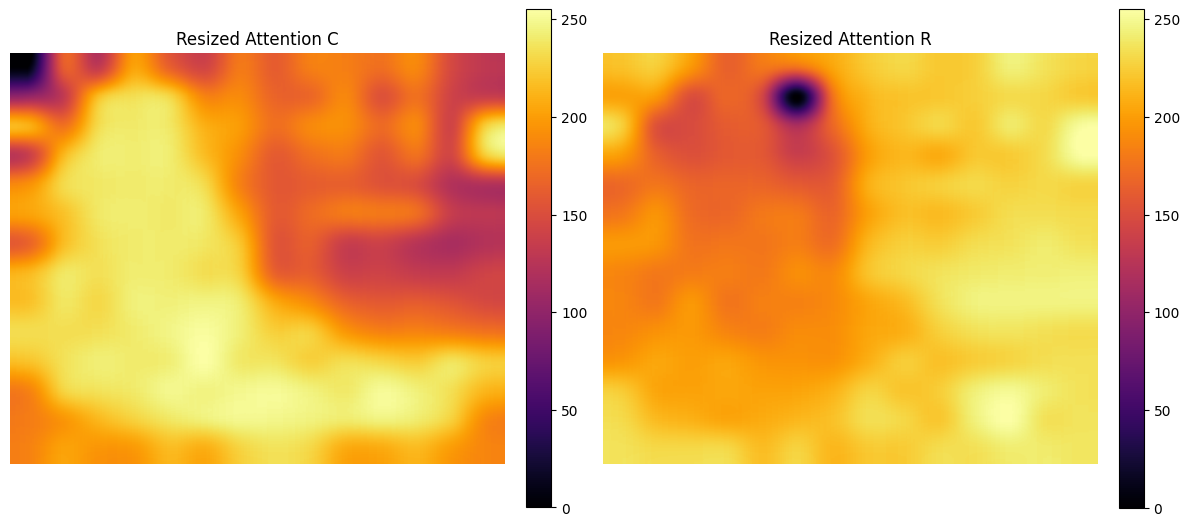

In [ ]:
# plt.figure(figsize=(6, 6))
# im = plt.imshow(cls_attention_resized_c, cmap='inferno')
# plt.title("Resized & Blurred Attention Map")
# plt.axis('off')
# plt.colorbar(im, fraction=0.046, pad=0.04)  # Adjust fraction/pad for size and spacing
# plt.show()

# plt.imshow(image)

# plt.figure(figsize=(6, 6))
# im2 = plt.imshow(cls_attention_resized_r, cmap='inferno')
# plt.title("Resized & Blurred Attention Map")
# plt.axis('off')
# plt.colorbar(im2, fraction=0.046, pad=0.04)
# plt.show()

fig, axis = plt.subplots(1, 2, figsize=(12, 6))

# First attention map
im1 = axis[0].imshow(cls_attention_resized_c, cmap='inferno')
axis[0].set_title("Resized Attention C")
axis[0].axis('off')
plt.colorbar(im1, ax=axis[0], fraction=0.046, pad=0.04)

# Second attention map
im2 = axis[1].imshow(cls_attention_resized_r, cmap='inferno')
axis[1].set_title("Resized Attention R")
axis[1].axis('off')
plt.colorbar(im2, ax=axis[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()



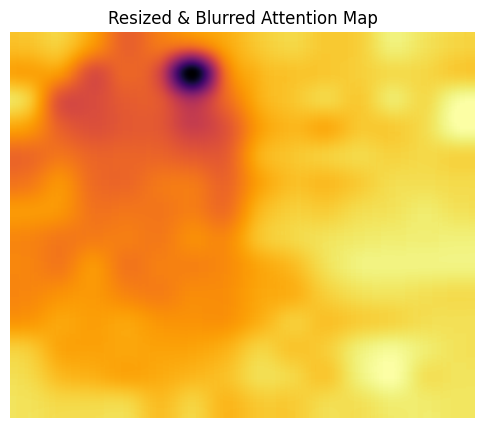

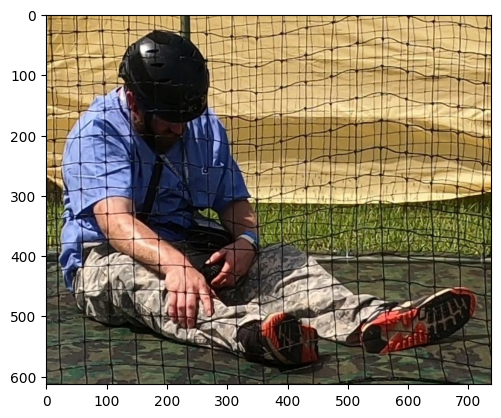

In [ ]:
plt.figure(figsize=(6, 6))
plt.imshow(cls_attention_resized_r, cmap='inferno')
plt.title("Resized & Blurred Attention Map")
plt.axis('off')
plt.show()
plt.imshow(image)

In [ ]:
# Convert the attention map to RGBA
# Choose either cls_attention_resized_c or cls_attention_resized_r
cls_attention_resized = cls_attention_resized_r  # or cls_attention_resized_c

cls_attention_colored = np.array(cls_attention_resized.convert("L"))
cls_attention_colored = np.stack([cls_attention_colored]*3 + [cls_attention_colored], axis=-1)

# Adjust the alpha channel to control brightness
cls_attention_colored_img = Image.fromarray(cls_attention_colored, mode="RGBA")
cls_attention_colored_img.putalpha(100)  # Adjust alpha for blending (lower value for darker overlay)

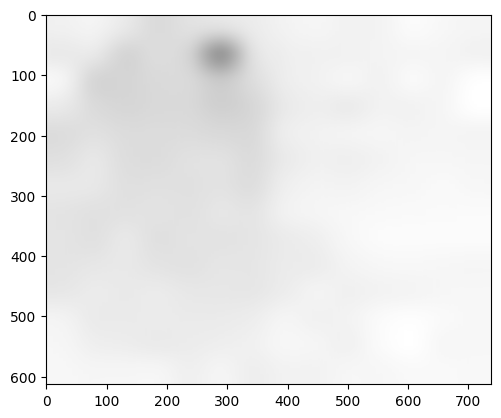

In [ ]:
plt.imshow(cls_attention_colored_img)